Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   
___
## Otimização da disposição de alvenaria em pórtico 2D

*Daniel B. M. Matos (PPGEC/UFRGS)*

*Letícia Fleck Fadel Miguel (PPGEC/UFGRS)*



___
* 1 Introdução
* 2 Modelagem matemática da estrutura
* 3 Aplicação de um sismo artificial
* 3.1 Otimização da disposição da alvenaria
* 3.2 Comparação dos resultados com e sem alvenaria
* 4 Aplicação de um sismo real
* 4.1 Otimização da disposição da alvenaria
* 4.2 Comparação dos resultados com e sem alvenaria
* 5 Análise por espectros de reposta
* 5.1 Otimizaçãoda disposição de alvenaria
___

### 1 Introdução
Este *Notebook* tem como finalidade avaliar a otimização da disposição de paredes de vedação no intuito de minimizar o *storydrift* em um pórtico de concreto armado. A estrutura em análise está exposta na Figura abaixo.


### 2 Modelagem matemática da estrutura
Primeiramente, importam-se os módulos necessários.

In [1]:
import Wall as wl                          # Módulo criado para a utilização das paredes.
from Wall import Vibmec as vib             # Classe para utilização de funções dinâmicas.
import numpy as np
import matplotlib.pyplot as plt
from pso import pso_simple                 # Módulo destinado a otimização por PSO.
from time import time
import scipy
from scipy import signal

Agora, cria-se um objeto ```Vibmec``` para a realização dos procedimentos dinâmicos.

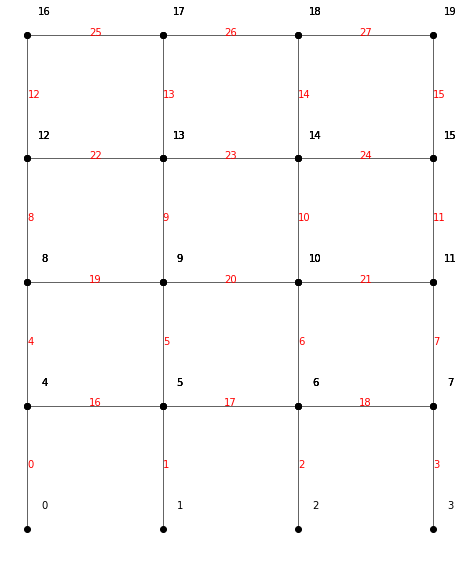

In [2]:
E = np.ones(150)*28*10**9
Port = vib('Resources/ARQUIVO_BASE.xlsx',20,E)
Port.DRAW()
plt.axis('off')
plt.savefig('Resources/Portico2.svg')

Utilizando os atributos da classe, é possível restringir os graus de liberdade da base, calcular os autovalores e autovetores e definir a matriz de amortecimento do objeto.

1 ª frequencia natural = 4.95Hz 

2 ª frequencia natural = 16.67Hz 

3 ª frequencia natural = 32.46Hz 



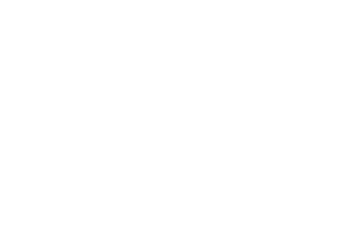

In [3]:
Port.Restr(np.arange(12))
Port.Eig(3,20)
plt.axis('off')
plt.savefig('modosp2.svg')
Port.Rayleigh(0.05,0.05)

### 3 Aplicação de um sismo artificial
Tendo o sistema modelado matematicamente, define-se o vetor de cargas com o auxílio do método de Shinouzuka e Jan, tendo como entrada o espectro de Kanai e Tajimi.

In [ ]:
Port.SeismicAceleration(0.5,'rocha',50,0.01,4.95)
age = Port.Envolve()
F1   = Port.Sismo(age)
d,v,a = Port.Newmark(F1,np.zeros(48),np.zeros(48),Port.time)


Afim de conferir a a frequência que concentra a maior energia no sistema, confecciona-se um periodograma

In [ ]:
plt.figure(16,figsize=(8,4))
f,Saz = scipy.signal.periodogram(age,(len(age)/np.max(Port.time)))
plt.plot(f,Saz,'k')
plt.xlabel('frequência(Hz)'); plt.ylabel('Densidade espectral(m²/s³)');
plt.xlim(0.5,20); plt.title(' Periodograma')
plt.ylim(0,0.4)
plt.grid(True)
plt.savefig('Resources/Periodograma2.svg')

#### 3.1 Otimização da disposição da alvenaria
Tendo em posse os valores de deslocamentos e de *Storydrifts*, inicia-se o processo de otimização estrutural. Para isso, utiliza-se o método *Particle Swarm Otimization* (PSO) para encontrar o pavimento em que a consideração da alvenaria de vedação como sistema de contraventamento minimiza o *Storydrift* do edifício.

In [ ]:
# Definição da função objetivo
def func1(x):
    
    Port.Wall(20,x,np.arange(12),6*10**-3)
    d1,v1,a1 = Port.Newmark(F1,np.zeros(48),np.zeros(48),Port.time,Wall = True)
    
    hd1    = d1[::12,:]
    umax1 = np.zeros(len(hd1[:]))

    for i in range(len(hd1[:])):
            
        umax1[i] = np.amax(hd1[i,:])
    sdmax1 = vib.Storydrift2(umax1)
    
    return np.max(sdmax1)

In [ ]:
initial = [2]           # Valor inicial
bounds  = [(0,3)]       # Valores limite
t1 = time()
e,p,i = pso_simple.minimize(func1, initial, bounds, num_particles=10, maxiter=10, verbose=True)
t2 = time()
print('O tempo de processamento foi de {:.2f} segundos'.format(t2-t1))

plt.plot(i,p,'k')
#plt.title('Curva de convergência')
plt.xlabel('iterações')
plt.ylabel('Valor da função objetivo (m)')
plt.grid(True)
plt.savefig('convergenciaest2.svg')


### 3.1 Comparação dos resultados
Após o processo de otmização, tendo em posse o pavimento em que a alvenaria minimiza o *Storydrift* do edifício, é possível plotar a comparação entre as duas simulações em termos de deslocamentos no último pavimento e máximo *storydrif* por andar.

In [ ]:
Port.Wall(20,e[-1],np.arange(12),6*10**-3)
d1,v1,a1 = Port.Newmark(F1,np.zeros(48),np.zeros(48),Port.time,Wall = True)
hd    = d[::12,:]
umax = np.zeros(len(hd[:]))

for i in range(len(hd[:])):
            
        umax[i] = np.amax(hd[i,:])
sdmax = vib.Storydrift2(umax)        

hd1    = d1[::12,:]
umax1 = np.zeros(len(hd1[:]))

for i in range(len(hd1[:])):
            
        umax1[i] = np.amax(hd1[i,:])
sdmax1 = vib.Storydrift2(umax1)

plt.figure(10,figsize=(8,4))
plt.plot(Port.time,d[45,:]*100,'b',label = 'Pórtico sem alvenaria de vedação.')
plt.plot(Port.time,d1[45,:]*100,'r',label = 'Pórtico com alvenaria de vedação.')
plt.xlabel('Tempo (s)'); plt.ylabel('Denslocamento (cm)');
plt.xlim(0,30); plt.ylim(-3,3); #plt.title('Deslocamento no último pavimento')
plt.legend()
plt.grid(True)

andar = np.arange(4)+1
plt.savefig('Resources/Deslocamentoest2.svg')
print(umax*100,umax1*100)

In [ ]:
plt.figure(3,figsize=(4,8))
plt.subplot(2,1,1)
plt.plot(sdmax*100,andar,'k:.',label='Sem parede de vedação')
plt.plot(sdmax1*100,andar,'r.-',label = 'Com parede de vedação')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend(loc='upper right',fontsize='x-small')
plt.grid(True)

r = np.zeros(len(sdmax))
r = (sdmax-sdmax1)/sdmax*100
plt.subplot(2,1,2)
plt.plot(r,andar,'k.-')
plt.xlabel('Redução percentual (%)')
plt.ylabel('Andar')
plt.grid(True)
plt.savefig('compstoryest2.svg')
print(sdmax*100,umax*100)

### 4. Aplicação de um carregamento real

Repete-se o mesmo procedimento a cima utilizando um carregamento real

431.832


<Figure size 432x288 with 0 Axes>

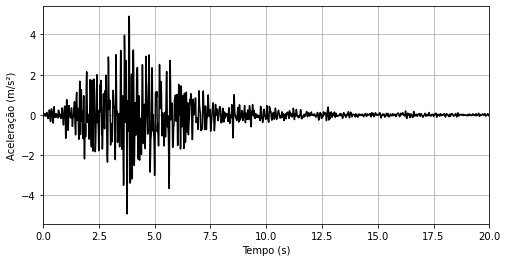

In [4]:
Port.SeismicAceleration(0.33,'rocha',50,0.01,2.76,'Resources/LomaPrieta2.txt')
plt.xlim(0,10)
ag = Port.signal/100
ag = ag/np.amax(ag)*0.5*9.81
F   = Port.Sismo(ag)
plt.clf()
d2,v2,a2 = Port.Newmark(F,np.zeros(48),np.zeros(48),Port.time)


hd2    = d2[::12,:]

umax2 = np.zeros(len(hd2[:]))

for i in range(len(hd2[:])):
            
    umax2[i] = np.amax(hd2[i,:])

sdmax2 = vib.Storydrift2(umax2)

plt.figure(1000,figsize=(8,4))
plt.plot(Port.time,ag,'k')
#plt.title('Sinal real')
plt.xlabel('Tempo (s)')
plt.xlim(0,20)
plt.ylabel('Aceleração (m/s²)')
plt.grid(True)
plt.savefig('Resources/ImperialValley.svg')


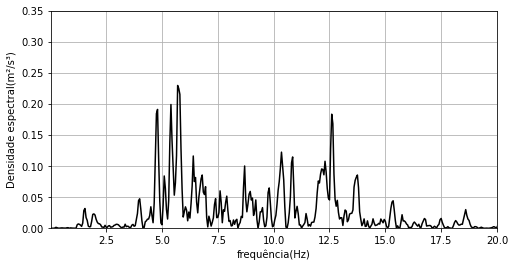

In [5]:
plt.figure(16,figsize=(8,4))
f,Saz = scipy.signal.periodogram(ag,(len(ag)/np.max(Port.time)))
plt.plot(f,Saz,'k')
plt.xlabel('frequência(Hz)'); plt.ylabel('Densidade espectral(m²/s³)');
plt.xlim(0.01,20); #plt.title(' Periodograma')
plt.ylim(0,0.35)
plt.grid(True)
plt.savefig('Resources/ImperialValley_P.svg')

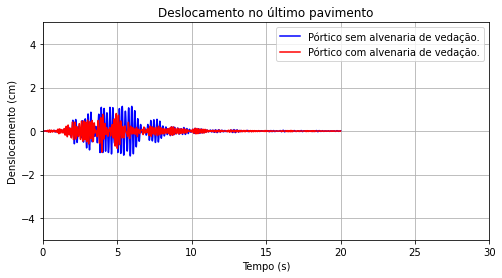

In [6]:
Port.Wall(20,0,np.arange(12),6*10**-3)
d3,v3,a3 = Port.Newmark(F,np.zeros(48),np.zeros(48),Port.time,Wall = True)

hd3    = d3[::12,:]

umax3 = np.zeros(len(hd3[:]))

for i in range(len(hd3[:])):
            
    umax3[i] = np.amax(hd3[i,:])

sdmax3 = vib.Storydrift2(umax3)


plt.figure(10,figsize=(8,4))
plt.plot(Port.time,d2[45,:]*100,'b',label = 'Pórtico sem alvenaria de vedação.')
plt.plot(Port.time,d3[45,:]*100,'r',label = 'Pórtico com alvenaria de vedação.')
plt.xlabel('Tempo (s)'); plt.ylabel('Denslocamento (cm)');
plt.xlim(0,30); plt.ylim(-5,5); plt.title('Deslocamento no último pavimento')
plt.legend()
plt.grid(True)

andar = np.arange(4) +1

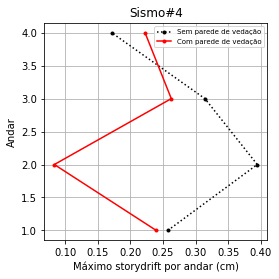

In [7]:
plt.figure(5,figsize=(4,4))

plt.plot(sdmax2*100,andar,'k:.',label='Sem parede de vedação')
plt.plot(sdmax3*100,andar,'r.-',label = 'Com parede de vedação')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.title('Sismo#4')
plt.legend(loc='upper right',fontsize='x-small')
plt.grid(True)
plt.savefig('sdsismo4.svg')

#r2 = np.zeros(len(sdmax2))
#r2 = (sdmax2-sdmax3)/sdmax2*100
#plt.subplot(1,2,2)
#plt.plot(r2,andar,'k.-')
#plt.xlabel('Redução percentual (%)')
#plt.ylabel('Andar')
#plt.grid(True)
#print(umax3*100)

## 5. Análise no domínio da frequência a partir do espectro de resposta

Realiza-se agora uma análise modal a partir do espectro de pseudoaceleração confeccionado a partir do sinal utilizado na análise no domínio do tempo 

In [8]:
import Pseudo 
def Pseudoacel(ag1,trace):
    wn =np.linspace(100,0.1,1000)
    u  = Pseudo.Duhamel(wn,ag1,Port.time)
    umax = np.zeros(len(wn))
    for i in range(len(wn)):
        umax[i] = np.amax(u[i,:])
    plt.figure(3,figsize=(12,4))
    ap = wn**2*umax
    plt.xscale('log')
    plt.plot(2*np.pi/wn,ap,trace)
    plt.title('Sismo#1')
    plt.xlabel('Período de oscilação(s)');plt.ylabel('Aceleração(m/s²)')
    #plt.xlim(0,3)
    #plt.ylim(0,0.02)
    plt.grid(True)
    
    return wn,ap

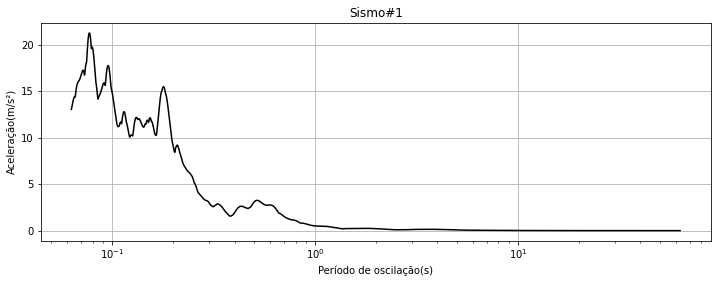

In [9]:
wn,ap = Pseudoacel(ag,'k')

In [10]:
nm = 1
Port.Modal_Analysis(F,np.zeros(48),np.zeros(48),3)

In [11]:
Fmax_p = Port.FreqDomain(ap,2*np.pi/wn)


Número de modos necessários = 2 Wi =  423.2643402065569 %


In [12]:
umax_1p = np.linalg.inv(Port.RestK)@Fmax_p
SQRSS_P = np.sqrt(np.sum(umax_1p**2,1))
print('O deslocamento máximo no domínio da frequência é:',np.max(SQRSS_P)*100,'cm')
print('O deslocamento máximo no domínio do tempo é:',np.amax(d2)*100,'cm')

O deslocamento máximo no domínio da frequência é: 1.1564475244094612 cm
O deslocamento máximo no domínio do tempo é: 1.1377833933423631 cm


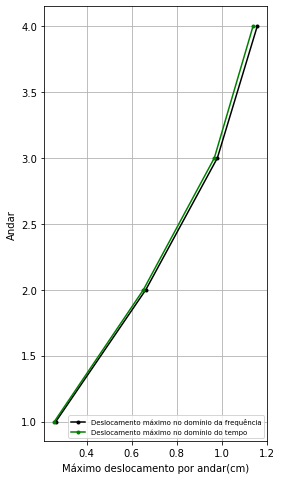

In [13]:
plt.figure(12,figsize=(4,8))
plt.plot(SQRSS_P[::12]*100,andar,'k.-',label = 'Deslocamento máximo no domínio da frequência')
plt.xlabel('Máximo deslocamento por andar(cm)')
plt.ylabel('Andar')
plt.grid(True)

plt.plot(umax2*100,andar,'g.-',label = 'Deslocamento máximo no domínio do tempo')
plt.legend(loc='lower right',fontsize='x-small')

[0.00264213]
[0.00264213 0.00662707 0.00979704 0.01156448]


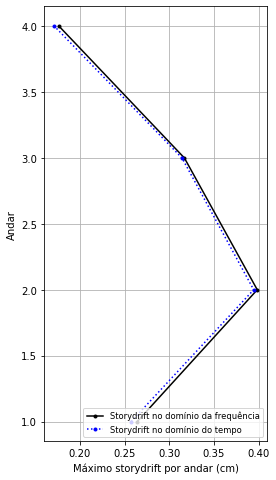

In [14]:
sdmax_f = vib.Storydrift2(SQRSS_P[::12])
plt.figure(12,figsize=(4,8))
plt.plot(sdmax_f*100,andar,'k.-',label='Storydrift no domínio da frequência')
plt.plot(sdmax2*100,andar,'b:.',label='Storydrift no domínio do tempo')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend()
plt.legend(loc='lower right',fontsize='small')
plt.grid(True)
print(sdmax_f[::12])
print(SQRSS_P[::12])

### 5.1 Otimização pelo método do espectro de resposta

In [15]:
def func2(x):
    Port.Wall(20,x,np.arange(12),6*10**-3)
    Port.Eig(3,20,Wall = True,Verbose = False)
    
    Fmax_p = Port.FreqDomain(ap,2*np.pi/wn,Verbose = False)
    umax_1p = np.linalg.inv(Port.W)@Fmax_p
    
    SQRSS_P = np.sqrt(np.sum(umax_1p**2,1))
    
    sdmax_f = vib.Storydrift2(SQRSS_P[::12]) 
        
    
        
    return np.amax(sdmax_f)

iter:    0, Melhor solução: -1.00000000, Andar: []
iter:    1, Melhor solução: 0.00519911, Andar: [2]
iter:    2, Melhor solução: 0.00425558, Andar: [1]
iter:    3, Melhor solução: 0.00262251, Andar: [0]
iter:    4, Melhor solução: 0.00262251, Andar: [0]
iter:    5, Melhor solução: 0.00262251, Andar: [0]
iter:    6, Melhor solução: 0.00262251, Andar: [0]
iter:    7, Melhor solução: 0.00262251, Andar: [0]
iter:    8, Melhor solução: 0.00262251, Andar: [0]
iter:    9, Melhor solução: 0.00262251, Andar: [0]

Solução final:
   > [0]
   > 0.0026225095968149805

O tempo de processamento foi de 4.13 segundos


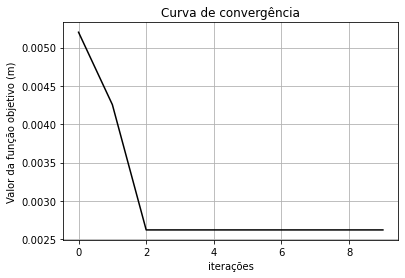

In [16]:
initial = [2]           # Valor inicial
bounds  = [(0,3)]       # Valores limite
t1 = time()

e3,p3,i3 = pso_simple.minimize(func2, initial, bounds, num_particles=10, maxiter=10, verbose=True)
t2 = time()
print('O tempo de processamento foi de {:.2f} segundos'.format(t2-t1))

plt.plot(i3,p3,'k')
plt.title('Curva de convergência')
plt.xlabel('iterações')
plt.ylabel('Valor da função objetivo (m)')
plt.grid(True)

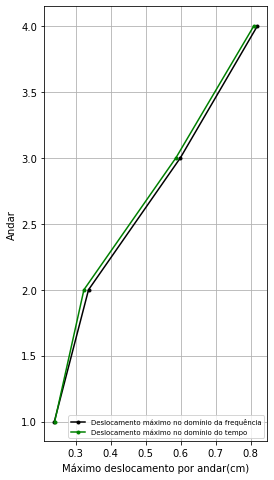

In [17]:
Port.Wall(20,0,np.arange(12),6*10**-3)
Port.Eig(3,20,Wall = True,Verbose = False) 
Fmax_p = Port.FreqDomain(ap,2*np.pi/wn,Verbose = False)
umax_2p = np.linalg.inv(Port.W)@Fmax_p
    
SQRSS_P2 = np.sqrt(np.sum(umax_2p**2,1))

plt.figure(12,figsize=(4,8))
plt.plot(SQRSS_P2[::12]*100,andar,'k.-',label = 'Deslocamento máximo no domínio da frequência')
plt.xlabel('Máximo deslocamento por andar(cm)')
plt.ylabel('Andar')
plt.grid(True)

      
plt.plot(umax3*100,andar,'g.-',label = 'Deslocamento máximo no domínio do tempo')
plt.legend(loc='lower right',fontsize='x-small')

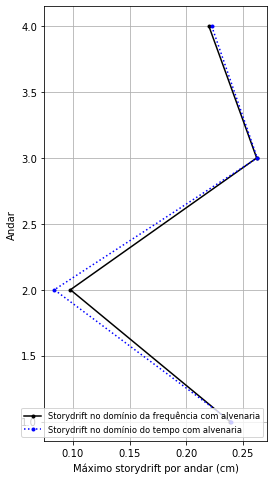

In [18]:

sdmax_f2 = vib.Storydrift2(SQRSS_P2[::12])

plt.figure(12,figsize=(4,8))
plt.plot(sdmax_f2*100,andar,'k.-',label='Storydrift no domínio da frequência com alvenaria')
plt.plot(sdmax3*100,andar,'b:.',label='Storydrift no domínio do tempo com alvenaria')
#plt.plot(abs(sdmax1[1:]-sdmax_f2[1:])/sdmax1[1:],andar[1:],'r:.',label='Erro percentual')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend()
plt.legend(loc='lower right',fontsize='small')
plt.grid(True)



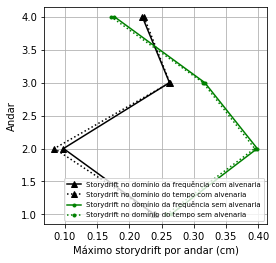

In [19]:
plt.figure(12,figsize=(4,4))
plt.plot(sdmax_f2*100,andar,'k^-',label='Storydrift no domínio da frequência com alvenaria')
plt.plot(sdmax3*100,andar,'k^:',label='Storydrift no domínio do tempo com alvenaria')
plt.plot(sdmax_f*100,andar,'g.-',label='Storydrift no domínio da frequência sem alvenaria')
plt.plot(sdmax2*100,andar,'g:.',label='Storydrift no domínio do tempo sem alvenaria')
#plt.plot(abs(sdmax1[1:]-sdmax_f2[1:])/sdmax1[1:],andar[1:],'r:.',label='Erro percentual')
plt.xlabel('Máximo storydrift por andar (cm)')
plt.ylabel('Andar')
plt.legend()
plt.legend(loc='lower right',fontsize='x-small')
plt.grid(True)

In [20]:
print(SQRSS_P2[::12]*100)
print(SQRSS_P[::12]*100)

[0.23869472 0.3364625  0.59871346 0.81877305]
[0.26421258 0.66270728 0.97970367 1.15644752]
